Problem Statement:

 The Titanic Problem is based on the sinking of the ‘Unsinkable’ ship Titanic in early 1912. 
It gives you information about multiple people like their ages, sexes, sibling counts, embarkment points, and whether or not they survived the disaster. Based on these features, you have to predict if an arbitrary passenger on Titanic would survive the sinking or not. 

In [60]:
#Importing neccesary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,LabelEncoder,power_transform
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,r2_score,roc_curve, roc_auc_score,auc
from sklearn.ensemble import ExtraTreesClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from scipy.stats import zscore
import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
df =pd.read_csv('titanic_train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

In [3]:
print('Number of rows x columns in dataset are:',df.shape)

Number of rows x columns in dataset are: (891, 12)


In [4]:
print('Dataset contains any null values:',df.isnull().values.any())

Dataset contains any null values: True


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Name,Sex,Ticket,Cabin,Embarked are categorical types

In [6]:
df = df.drop(columns = ['PassengerId','Name','Ticket'])

droping columns that are not of relevance to determination of survivable rate

In [7]:
print('Number of rows x columns in dataset are:',df.shape)

Number of rows x columns in dataset are: (891, 9)


In [8]:
#Looking for null values
print(df.isnull().sum())

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64


There are missing values in Age,Cabin,Embarked columns

<AxesSubplot:>

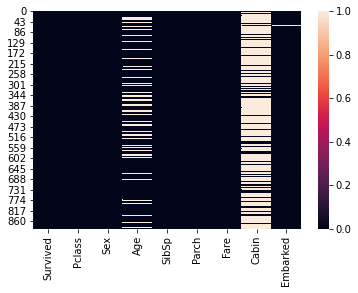

In [9]:
sns.heatmap(df.isnull())

heatmap shows missing values

In [10]:
le = LabelEncoder()
sx = le.fit_transform(df['Sex'])
pd.Series(sx)
df['Sex'] = sx

In [11]:
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

###### Using mode to replace null in 'Cabin' column 

In [12]:
df['Cabin'] = df['Cabin'].fillna(df['Cabin'].mode()[0])

In [13]:
cb =  le.fit_transform(df['Cabin'])
pd.Series(cb)
df['Cabin'] = cb

In [14]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,1,22.0,1,0,7.2500,47,S
1,1,1,0,38.0,1,0,71.2833,81,C
2,1,3,0,26.0,0,0,7.9250,47,S
3,1,1,0,35.0,1,0,53.1000,55,S
4,0,3,1,35.0,0,0,8.0500,47,S


###### Using mode to replace null in 'Embarked' column 

In [15]:
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

In [16]:
em =  le.fit_transform(df['Embarked'])
pd.Series(em)
df['Embarked'] = em

###### Using median to fill null values in 'Age' column

In [17]:
df['Age'] = df['Age'].fillna(df['Age'].median())

<AxesSubplot:xlabel='Age', ylabel='Density'>

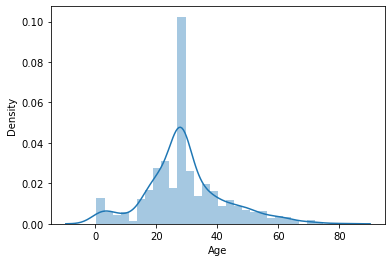

In [18]:
sns.distplot(df['Age'])

Age is normally distributed

Checking for null values

In [19]:
df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Cabin       0
Embarked    0
dtype: int64

###### Null value problem seems to be cleared

Checking for class imbalance

In [20]:
df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

<AxesSubplot:xlabel='Survived', ylabel='count'>

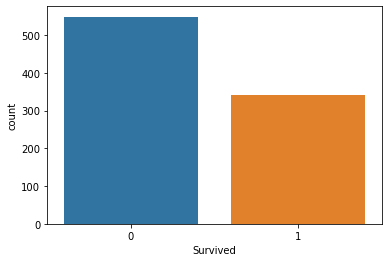

In [21]:
sns.countplot(x='Survived',data=df)

##### Correlation

In [22]:
corr_data = df.corr()
corr_data['Survived'].sort_values(ascending = False)

Survived    1.000000
Fare        0.257307
Cabin       0.175690
Parch       0.081629
SibSp      -0.035322
Age        -0.064910
Embarked   -0.167675
Pclass     -0.338481
Sex        -0.543351
Name: Survived, dtype: float64

Sex is high correlated than resty

<AxesSubplot:>

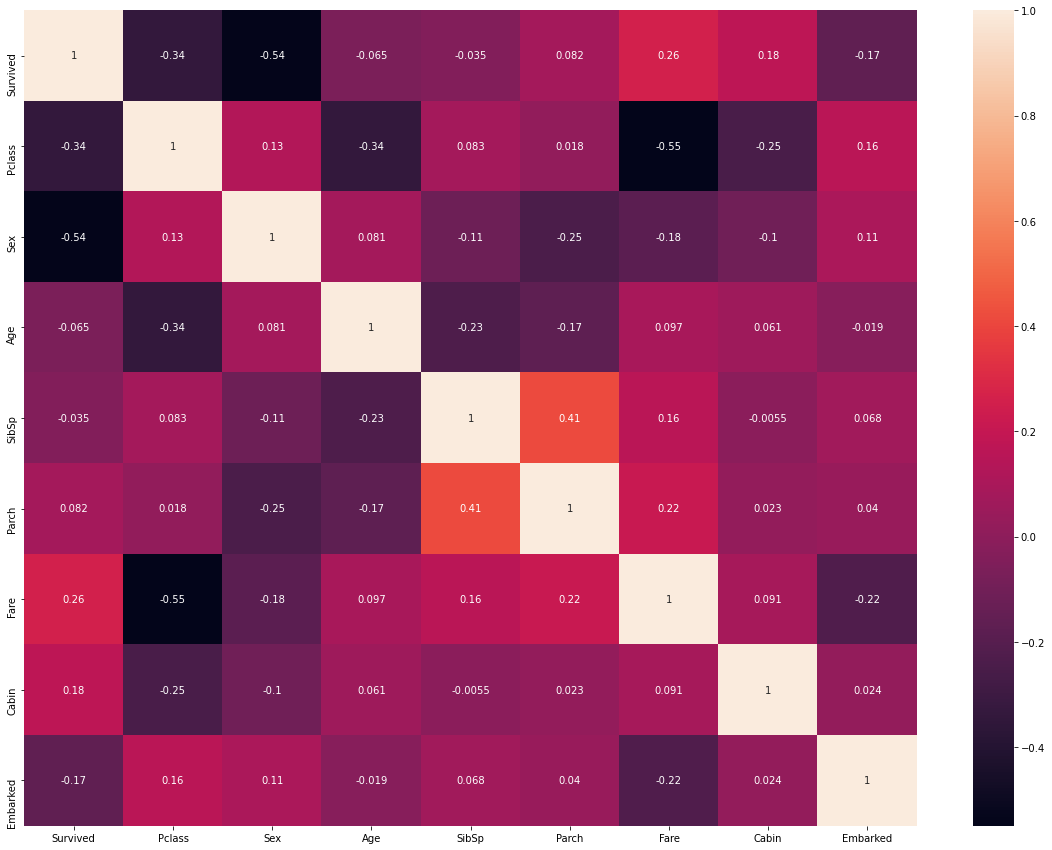

In [23]:
plt.figure(figsize = (20,15))
sns.heatmap(corr_data,annot =True)

#### Outliers

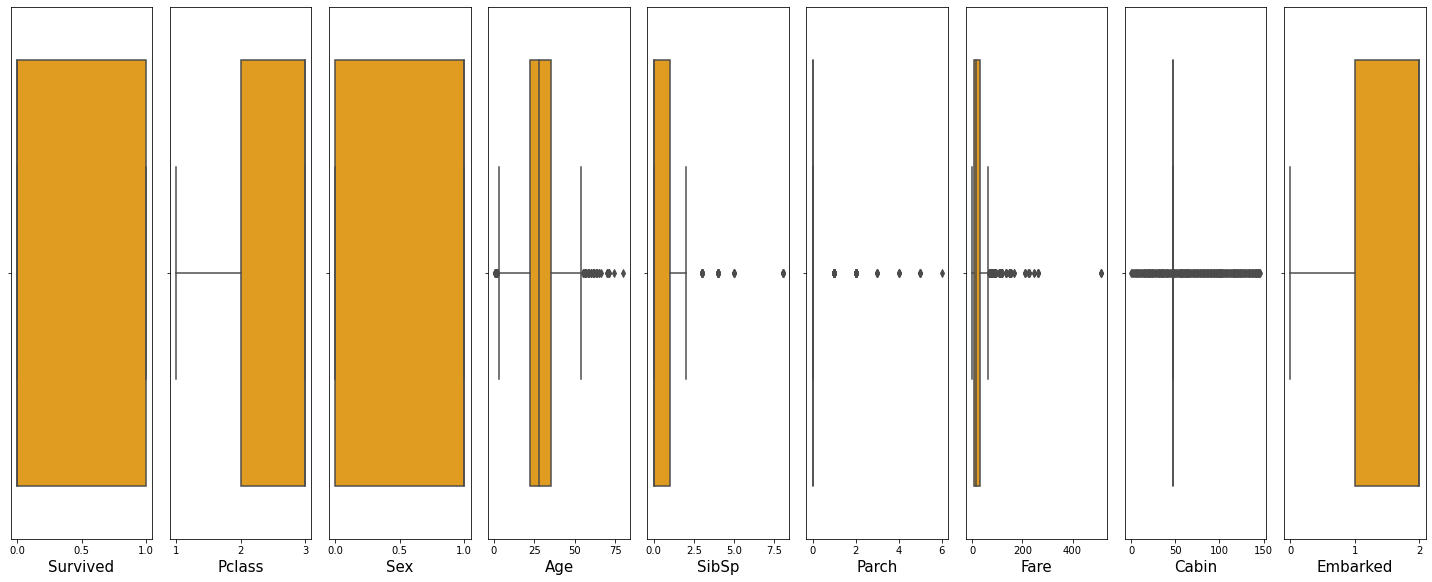

In [24]:
plt.figure(figsize = (20,80))
plotnum = 1

for i in df:
    if plotnum<= 90:
        sc = plt.subplot(10,9,plotnum)
        sns.boxplot(df[i],color = 'orange', orient ='v')
        plt.xlabel(i,fontsize = 15)
    plotnum+=1
plt.tight_layout()

###### Age and Fare has more outliers

#### Checking Distribution

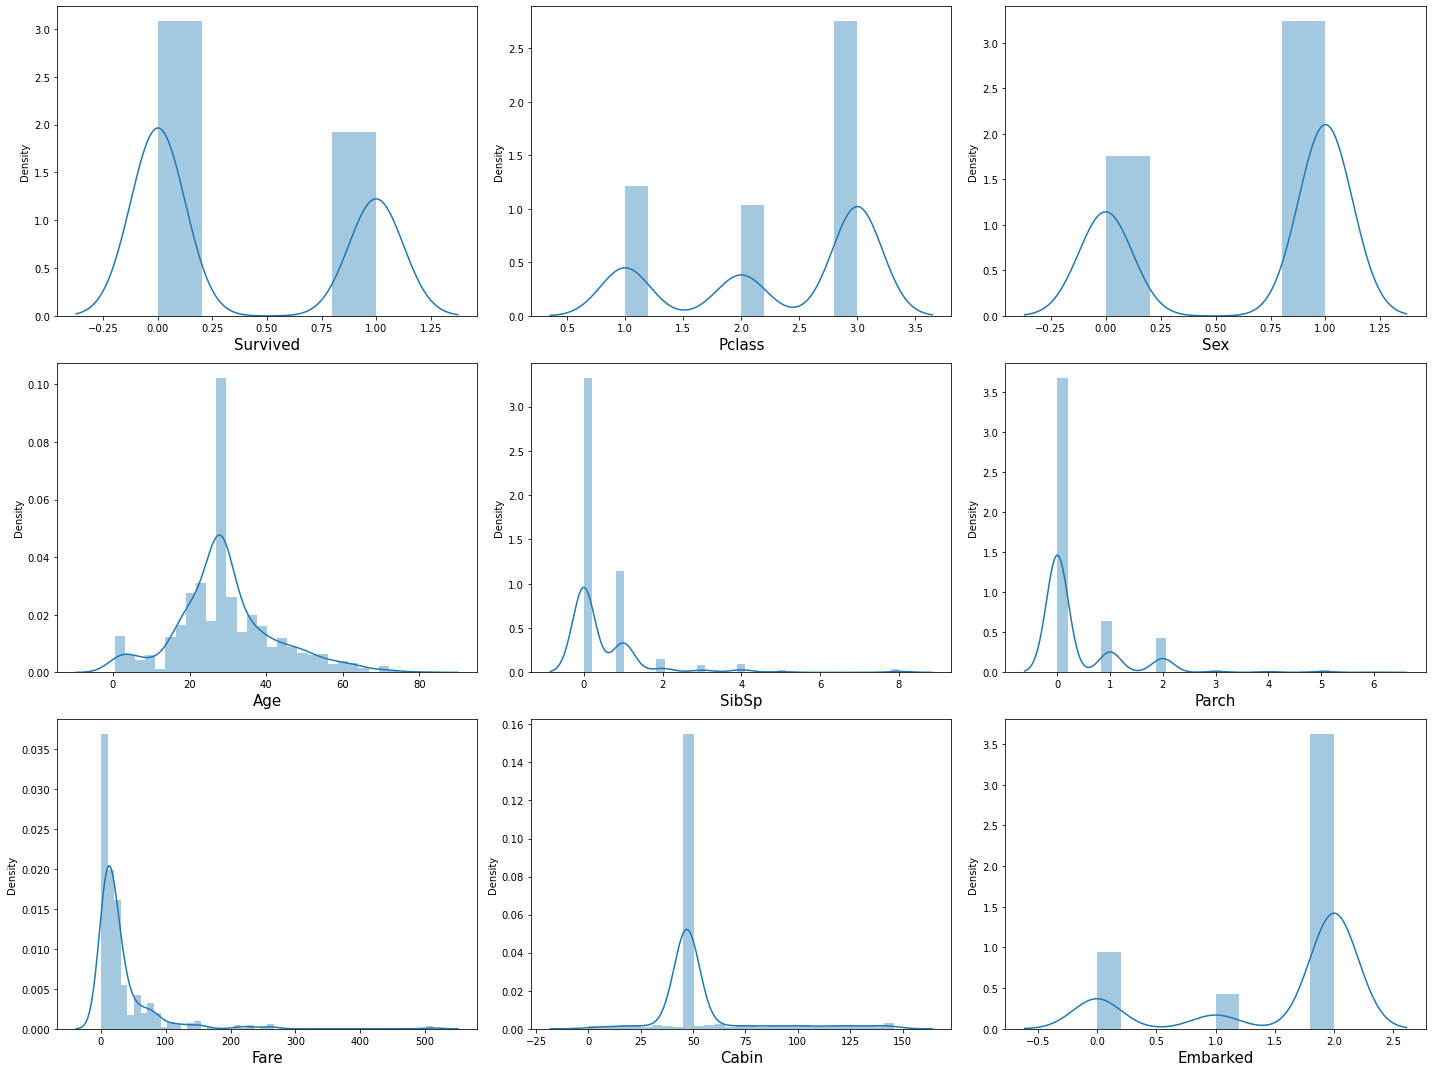

In [25]:
plt.figure(figsize = (20,15))
plotnum = 1

for i in df:
    if plotnum<= 9:
        sc = plt.subplot(3,3,plotnum)
        sns.distplot(df[i])
        plt.xlabel(i,fontsize = 15)
    plotnum+=1
plt.tight_layout()

###### most data is categortical but age and fare are skewed

Parch has most '0' values

In [26]:
df['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [27]:
df['Parch'] = np.where(df['Parch']== 3,0,
                           np.where(df['Parch']==4,0,
                                    np.where(df['Parch']==5,0,
                                            np.where(df['Parch']==6,0,df['Parch']))))

##### Remove outliers

In [28]:
z = np.abs(zscore(df))
z

array([[0.78927234, 0.82737724, 0.73769513, ..., 0.50244517, 0.28188124,
        0.58595414],
       [1.2669898 , 1.56610693, 1.35557354, ..., 0.78684529, 1.16154512,
        1.9423032 ],
       [1.2669898 , 0.82737724, 1.35557354, ..., 0.48885426, 0.28188124,
        0.58595414],
       ...,
       [0.78927234, 0.82737724, 1.35557354, ..., 0.17626324, 0.28188124,
        0.58595414],
       [1.2669898 , 1.56610693, 0.73769513, ..., 0.04438104, 0.27001707,
        1.9423032 ],
       [0.78927234, 0.82737724, 0.73769513, ..., 0.49237783, 0.28188124,
        0.67817453]])

In [29]:
z_df = df[(z<3).all(axis = 1)]
print(df.shape)
print(z_df.shape)

(891, 9)
(800, 9)


In [30]:
((891-807)/891)*100

9.427609427609427

data loss of 9.43%

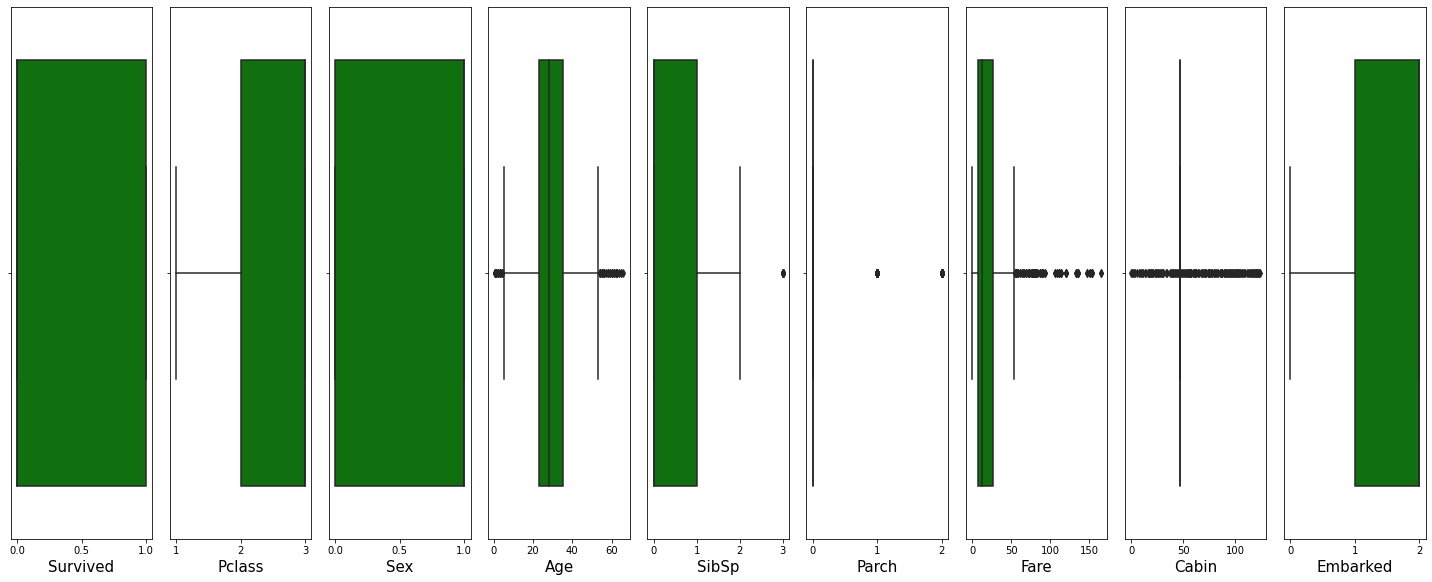

In [31]:
plt.figure(figsize = (20,80))
plotnum = 1

for i in z_df:
    if plotnum<= 90:
        sc = plt.subplot(10,9,plotnum)
        sns.boxplot(z_df[i],color = 'green', orient ='v')
        plt.xlabel(i,fontsize = 15)
    plotnum+=1
plt.tight_layout()

still some outliers in fare

In [32]:
z_df.skew()

Survived    0.489910
Pclass     -0.703890
Sex        -0.659188
Age         0.436779
SibSp       1.983219
Parch       2.232901
Fare        2.393969
Cabin       2.163778
Embarked   -1.272006
dtype: float64

fare has highest skewness

In [33]:
x =  z_df.drop(columns = 'Survived')
y = z_df['Survived']

##### removing skewness

In [34]:
tr_data = power_transform(x,method ='yeo-johnson')
x = pd.DataFrame(tr_data,columns = x.columns)

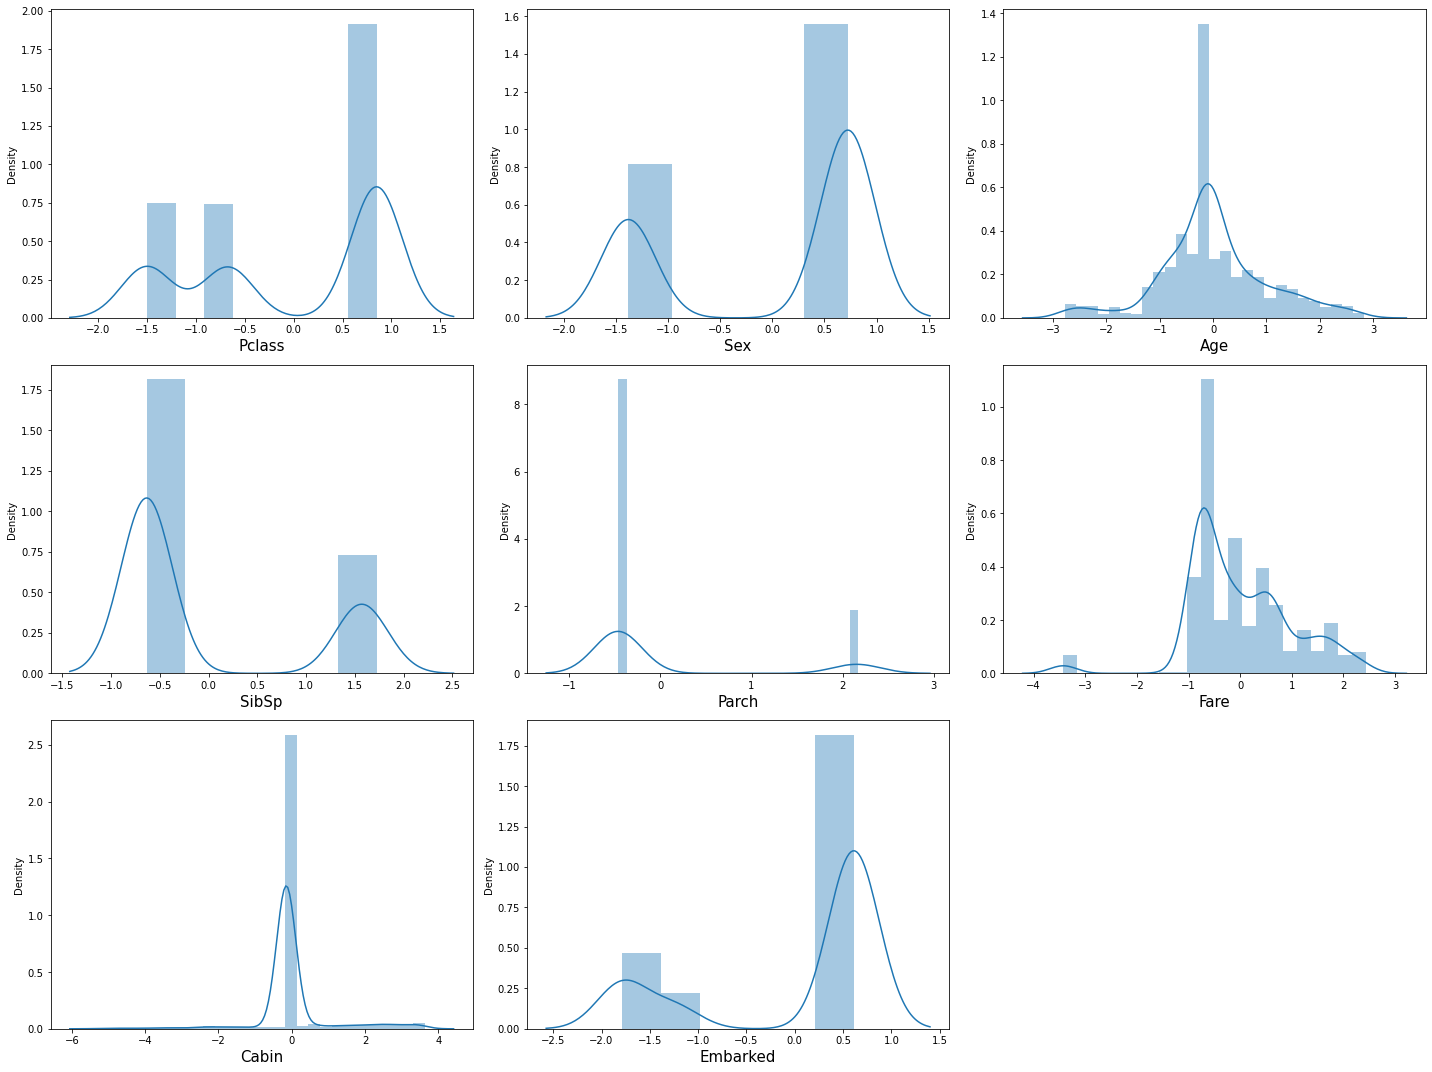

In [35]:
plt.figure(figsize = (20,15))
plotnum = 1

for i in x:
    if plotnum<= 9:
        sc = plt.subplot(3,3,plotnum)
        sns.distplot(x[i])
        plt.xlabel(i,fontsize = 15)
    plotnum+=1
plt.tight_layout()

###### we decide to drop fare as outliers and skewness is not getting removed

In [36]:
x = x.drop(columns = 'Fare',axis = 0)

#### Balancing dataset

In [37]:
sm =SMOTE()
x_over,y_over = sm.fit_resample(x,y)

#### Finding best random state

In [38]:
maxAccu=0
maxRS=0
for i in range(1,100):
    x_train,x_test,y_train,y_test=train_test_split(x_over,y_over,test_size=.20,random_state=i)
    mod= RandomForestClassifier()
    mod.fit(x_train,y_train)
    pred=mod.predict(x_test)
    acc=accuracy_score(y_test,pred)
    if acc>maxAccu:
        maxAccu=acc
        maxRS=i
print ('best accuracy is',maxAccu,'on random state',maxRS)

best accuracy is 0.8686868686868687 on random state 83


In [39]:
x_train,x_test,y_train,y_test=train_test_split(x_over,y_over,test_size=.20,random_state=maxRS)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(792, 7)
(198, 7)
(792,)
(198,)


792 rows for training and 198 rows for tetsing

### Model building & evaluation

In [40]:
#ExtraTreesClassifier model
etc= ExtraTreesClassifier()
etc.fit(x_train,y_train)
predetc=etc.predict(x_test)
etc.score(x_train,y_train)
etc_acc = accuracy_score(y_test,predetc)
print(etc_acc)
print(confusion_matrix(y_test,predetc))
print(classification_report(y_test,predetc))

0.8737373737373737
[[92 10]
 [15 81]]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       102
           1       0.89      0.84      0.87        96

    accuracy                           0.87       198
   macro avg       0.87      0.87      0.87       198
weighted avg       0.87      0.87      0.87       198



In [41]:
#RandomForest classifcation Model
rf= RandomForestClassifier()
rf.fit(x_train,y_train)
predrf=rf.predict(x_test)
rf.score(x_train,y_train)
rf_acc = accuracy_score(y_test,predrf)
print(rf_acc)
print(confusion_matrix(y_test,predrf))
print(classification_report(y_test,predrf))

0.8636363636363636
[[90 12]
 [15 81]]
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       102
           1       0.87      0.84      0.86        96

    accuracy                           0.86       198
   macro avg       0.86      0.86      0.86       198
weighted avg       0.86      0.86      0.86       198



In [42]:
#XGBClassifier Model
xgb= XGBClassifier()
xgb.fit(x_train,y_train)
predxgb=xgb.predict(x_test)
xgb.score(x_train,y_train)
xgb_acc= accuracy_score(y_test,predxgb)
print(xgb_acc)
print(confusion_matrix(y_test,predxgb))
print(classification_report(y_test,predxgb))

0.8484848484848485
[[89 13]
 [17 79]]
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       102
           1       0.86      0.82      0.84        96

    accuracy                           0.85       198
   macro avg       0.85      0.85      0.85       198
weighted avg       0.85      0.85      0.85       198



In [43]:
knc= KNeighborsClassifier()
knc.fit(x_train,y_train)
predknc=knc.predict(x_test)
knc.score(x_train,y_train)
knc_acc = accuracy_score(y_test,predknc) 
print(knc_acc)
print(confusion_matrix(y_test,predknc))
print(classification_report(y_test,predknc))

0.8484848484848485
[[90 12]
 [18 78]]
              precision    recall  f1-score   support

           0       0.83      0.88      0.86       102
           1       0.87      0.81      0.84        96

    accuracy                           0.85       198
   macro avg       0.85      0.85      0.85       198
weighted avg       0.85      0.85      0.85       198



In [44]:
#BaggingClassifier model
bc= BaggingClassifier()
bc.fit(x_train,y_train)
predbc=bc.predict(x_test)
bc.score(x_train,y_train)
bc_acc = accuracy_score(y_test,predbc)
print(bc_acc)
print(confusion_matrix(y_test,predbc))
print(classification_report(y_test,predbc))

0.8484848484848485
[[89 13]
 [17 79]]
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       102
           1       0.86      0.82      0.84        96

    accuracy                           0.85       198
   macro avg       0.85      0.85      0.85       198
weighted avg       0.85      0.85      0.85       198



### Cross Validation 

In [45]:
cv1 = cross_val_score(etc,x,y,cv =5)
cv1 = cv1.mean()
cv1

0.7875

In [46]:
cv2 = cross_val_score(rf,x,y,cv =5)
cv2 = cv2.mean()
cv2

0.8075000000000001

In [47]:
cv3 = cross_val_score(xgb,x,y,cv =5)
cv3 = cv3.mean()
cv3

0.80375

In [48]:
cv4 = cross_val_score(knc,x,y,cv =5)
cv4 = cv4.mean()
cv4

0.81875

In [49]:
cv5 = cross_val_score(bc,x,y,cv =5)
cv5 = cv5.mean()
cv5

0.79125

In [50]:
mod = [etc_acc, rf_acc, xgb_acc, knc_acc, bc_acc]
cv = [cv1,cv2,cv3,cv4,cv5]
mod_sel =pd.DataFrame({})
mod_sel['mod'] = mod
mod_sel['cv'] = cv
mod_sel['diff'] = mod_sel['mod'] - mod_sel['cv']
mod_sel

,mod,cv,diff
0,0.873737,0.78750,0.086237
1,0.863636,0.80750,0.056136
2,0.848485,0.80375,0.044735
3,0.848485,0.81875,0.029735
4,0.848485,0.79125,0.057235


##### KNeighborsClassifier has least difference and best model

### Hyperparameter Tuning

In [51]:
parameters = {'n_neighbors' : [5,7,9,11,13,15],
              'weights':['uniform', 'distance'],
              'metric' : ['minkowski','euclidean','manhattan']
             }

In [54]:
gcv = GridSearchCV(knc, parameters, cv=5)

In [55]:
gcv.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'euclidean', 'manhattan'],
                         'n_neighbors': [5, 7, 9, 11, 13, 15],
                         'weights': ['uniform', 'distance']})

In [56]:
gcv.best_params_

{'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}

#### Final Model

In [58]:
knc_f= KNeighborsClassifier(metric= 'manhattan', n_neighbors= 9, weights= 'distance')
knc_f.fit(x_train,y_train)
predknc=knc_f.predict(x_test)
knc_f.score(x_train,y_train)
knc_facc = accuracy_score(y_test,predknc) 
print(knc_facc)
print(confusion_matrix(y_test,predknc))
print(classification_report(y_test,predknc))

0.8737373737373737
[[93  9]
 [16 80]]
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       102
           1       0.90      0.83      0.86        96

    accuracy                           0.87       198
   macro avg       0.88      0.87      0.87       198
weighted avg       0.88      0.87      0.87       198



### Auc_Roc Curve

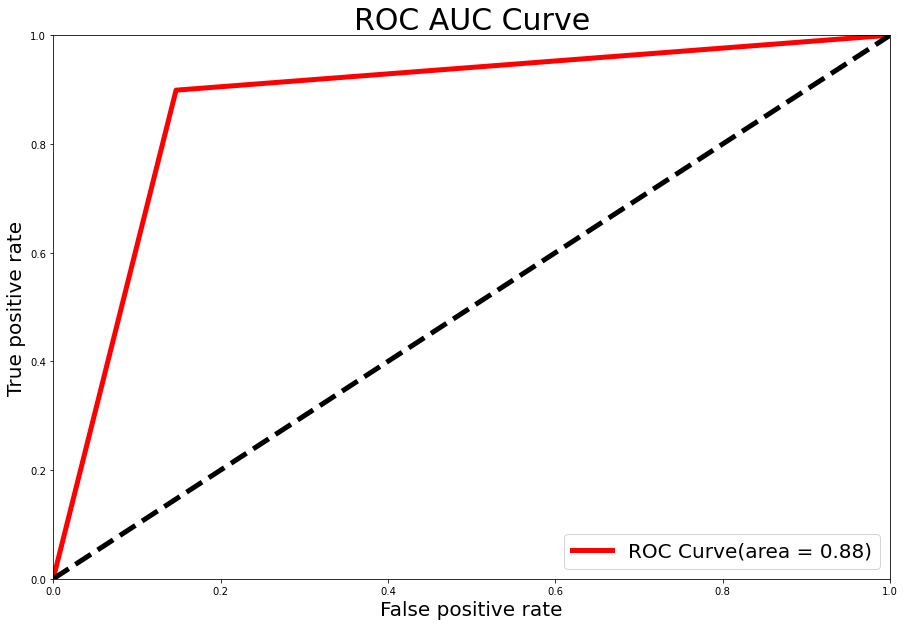

In [62]:
fpr,tpr, thresholds = roc_curve(predknc,y_test)
roc_auc = auc(fpr,tpr)

plt.figure(figsize = (15,10))
plt.plot(fpr,tpr,lw = 5, color = 'red',label = 'ROC Curve(area = %0.2f)'%roc_auc)
plt.plot([0,1],[0,1],lw =5, color ='black', linestyle = '--')
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.xlabel('False positive rate', fontsize = 20)
plt.ylabel('True positive rate', fontsize  =20)
plt.title('ROC AUC Curve', fontsize = 30)
plt.legend(loc ='lower right', fontsize = 20)
plt.show()

### Saving the model

In [63]:
joblib.dump(knc_f, 'Titanic.pkl')

['Titanic.pkl']